#### 导入库

In [1]:
import torch
import importlib
from tensorboardX import SummaryWriter
import torch.nn.utils.rnn as rnn_utils
import pickle
import tqdm
import os
import torch.nn as nn
import sys

In [2]:
sys.path.append(".")

In [3]:
from dataUtilsV0 import *

load glove finished


In [4]:
import json

In [5]:
from collections import deque

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

### 数据集分析

In [9]:
with open("../../config.json", "r") as cr:
    dic = json.load(cr)

class adict(dict):
    ''' Attribute dictionary - a convenience data structure, similar to SimpleNamespace in python 3.3
        One can use attributes to read/write dictionary content.
    '''
    def __init__(self, *av, **kav):
        dict.__init__(self, *av, **kav)
        self.__dict__ = self

FLAGS = adict(dic)

In [10]:
load_data_fast()

max_sent: 308 ,  max_seq_len: 346
5802 data loaded


In [10]:
load_data("/home/hadoop/pheme-rnr-dataset/", FLAGS)

KeyboardInterrupt: 

In [11]:
del data
del data_ID
del data_y
del data_len
from dataUtils import data
from dataUtils import data_ID
from dataUtils import data_y
from dataUtils import data_len

In [12]:
import time

In [13]:
t_hour = [(data[data_ID[i]]['created_at'][-1]-data[data_ID[i]]['created_at'][0])/3600.0 for i in range(len(data_ID))] 

In [14]:
import seaborn as sns

In [41]:
def plot_hist(x_tuples, bins, xlabel, ylabel, legends, title):
    colors = [(1, 0, 0), (1, 1, 0), (0, 1, 0,), (0, 0, 1)]
    def normfun(x,mu,sigma):
        pdf = np.exp(-((x - mu)**2)/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
        return pdf
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
#     plt.xlim(0, 200)
    for i in range(len(x_tuples)):
        sns.distplot(x_tuples[i], bins=bins, rug=False, kde=True, hist=True, norm_hist=True, label=legends[i], hist_kws={"histtype": "step", "linewidth": 2,
        "alpha": 1}, kde_kws={"color": colors[0], "lw": 0, "label": ""})

In [16]:
import matplotlib.pyplot as plt

In [28]:
len(t_hour), max(t_hour), min(t_hour)

(5802, 728.7561111111111, 0.0)

In [38]:
max(data_len), min(data_len)

(346, 1)

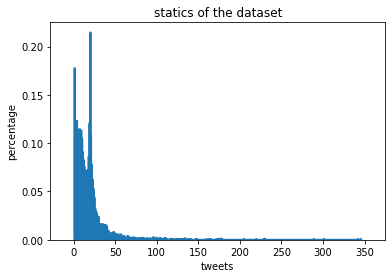

In [42]:
plot_hist([data_len], 1000, "tweets", "percentage", [""], "statics of the dataset")

### 切割数据集

In [43]:
len(data_ID), len(data_y), len(data_len)

(5802, 5802, 5802)

In [52]:
new_y =[]
new_ID = []
new_len = []

for l, ID, y in zip(data_len, data_ID, data_y):
    if l > 5:
        new_len.append(l)
        new_ID.append(ID)
        new_y.append(y)

In [53]:
len(new_ID), len(new_len), len(new_y)

(4604, 4604, 4604)

In [62]:
with open('data/data_dict.txt', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
np.save("data/data_ID.npy", np.array(new_ID)[:-500])
np.save("data/data_len.npy", np.array(new_len)[:-500])
np.save("data/data_y.npy", np.array(new_y)[:-500])

np.save("data/test_data_ID.npy", np.array(new_ID)[-500:])
np.save("data/test_data_len.npy", np.array(new_len)[-500:])
np.save("data/test_data_y.npy", np.array(new_y)[-500:])

### 模型训练与测试

In [10]:

class LayerNormLSTMCell(nn.LSTMCell):
    def __init__(self, input_size, hidden_size, dropout=0.0, bias=True, use_layer_norm=True):
        super().__init__(input_size, hidden_size, bias)
        self.use_layer_norm = use_layer_norm
        if self.use_layer_norm:
            self.ln_ih = nn.LayerNorm(4 * hidden_size)
            self.ln_hh = nn.LayerNorm(4 * hidden_size)
            self.ln_ho = nn.LayerNorm(hidden_size)
        # DropConnect on the recurrent hidden to hidden weight
        self.dropout = dropout

    def forward(self, input, hidden=None):
        self.check_forward_input(input)
        if hidden is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            cx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
        else:
            hx, cx = hidden
        self.check_forward_hidden(input, hx, '[0]')
        self.check_forward_hidden(input, cx, '[1]')

        weight_hh = nn.functional.dropout(self.weight_hh, p=self.dropout, training=self.training)
        if self.use_layer_norm:
            gates = self.ln_ih(F.linear(input, self.weight_ih, self.bias_ih)) \
                     + self.ln_hh(F.linear(hx, weight_hh, self.bias_hh))
        else:
            gates = F.linear(input, self.weight_ih, self.bias_ih) \
                    + F.linear(hx, weight_hh, self.bias_hh)

        i, f, c, o = gates.chunk(4, 1)
        i_ = torch.sigmoid(i)
        f_ = torch.sigmoid(f)
        c_ = torch.tanh(c)
        o_ = torch.sigmoid(o)
        cy = (f_ * cx) + (i_ * c_)
        if self.use_layer_norm:
            hy = o_ * self.ln_ho(torch.tanh(cy))
        else:
            hy = o_ * torch.tanh(cy)
        return hy, cy

class LayerNormLSTM(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers=1,
                 dropout=0.0,
                 weight_dropout=0.0,
                 bias=True,
                 bidirectional=False,
                 use_layer_norm=True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # using variational dropout
        self.dropout = dropout
        self.bidirectional = bidirectional

        num_directions = 2 if bidirectional else 1
        self.hidden0 = nn.ModuleList([
            LayerNormLSTMCell(input_size=(input_size if layer == 0 else hidden_size * num_directions),
                              hidden_size=hidden_size, dropout=weight_dropout, bias=bias, use_layer_norm=use_layer_norm)
            for layer in range(num_layers)
        ])

        if self.bidirectional:
            self.hidden1 = nn.ModuleList([
                LayerNormLSTMCell(input_size=(input_size if layer == 0 else hidden_size * num_directions),
                                  hidden_size=hidden_size, dropout=weight_dropout, bias=bias, use_layer_norm=use_layer_norm)
                for layer in range(num_layers)
            ])

    def copy_parameters(self, rnn_old):
        for param in rnn_old.named_parameters():
            name_ = param[0].split("_")
            layer = int(name_[2].replace("l", ""))
            sub_name = "_".join(name_[:2])
            if len(name_) > 3:
                self.hidden1[layer].register_parameter(sub_name, param[1])
            else:
                self.hidden0[layer].register_parameter(sub_name, param[1])

    def forward(self, input, hidden=None, seq_lens=None):
        seq_len, batch_size, _ = input.size()
        num_directions = 2 if self.bidirectional else 1
        if hidden is None:
            hx = input.new_zeros(self.num_layers * num_directions, batch_size, self.hidden_size, requires_grad=False)
            cx = input.new_zeros(self.num_layers * num_directions, batch_size, self.hidden_size, requires_grad=False)
        else:
            hx, cx = hidden

        ht = []
        for i in range(seq_len):
            ht.append([None] * (self.num_layers * num_directions))
        ct = []
        for i in range(seq_len):
            ct.append([None] * (self.num_layers * num_directions))

        seq_len_mask = input.new_ones(batch_size, seq_len, self.hidden_size, requires_grad=False)
        if seq_lens != None:
            for i, l in enumerate(seq_lens):
                seq_len_mask[i, l:, :] = 0
        seq_len_mask = seq_len_mask.transpose(0, 1)

        if self.bidirectional:
            # if use cuda, change 'torch.LongTensor' to 'torch.cuda.LongTensor'
            indices_ = (torch.LongTensor(seq_lens) - 1).unsqueeze(1).unsqueeze(0).unsqueeze(0).repeat(
                [1, 1, 1, self.hidden_size])
            # if use cuda, change 'torch.LongTensor' to 'torch.cuda.LongTensor'
            indices_reverse = torch.LongTensor([0] * batch_size).unsqueeze(1).unsqueeze(0).unsqueeze(0).repeat(
                [1, 1, 1, self.hidden_size])
            indices = torch.cat((indices_, indices_reverse), dim=1)
            hy = []
            cy = []
            xs = input
            # Variational Dropout
            if not self.training or self.dropout == 0:
                dropout_mask = input.new_ones(self.num_layers, 2, batch_size, self.hidden_size)
            else:
                dropout_mask = input.new(self.num_layers, 2, batch_size, self.hidden_size).bernoulli_(1 - self.dropout)
                dropout_mask = Variable(dropout_mask, requires_grad=False) / (1 - self.dropout)

            for l, (layer0, layer1) in enumerate(zip(self.hidden0, self.hidden1)):
                l0, l1 = 2 * l, 2 * l + 1
                h0, c0, h1, c1 = hx[l0], cx[l0], hx[l1], cx[l1]
                for t, (x0, x1) in enumerate(zip(xs, reversed(xs))):
                    ht_, ct_ = layer0(x0, (h0, c0))
                    ht[t][l0] = ht_ * seq_len_mask[t]
                    ct[t][l0] = ct_ * seq_len_mask[t]
                    h0, c0 = ht[t][l0], ct[t][l0]
                    t = seq_len - 1 - t
                    ht_, ct_ = layer1(x1, (h1, c1))
                    ht[t][l1] = ht_ * seq_len_mask[t]
                    ct[t][l1] = ct_ * seq_len_mask[t]
                    h1, c1 = ht[t][l1], ct[t][l1]

                xs = [torch.cat((h[l0]*dropout_mask[l][0], h[l1]*dropout_mask[l][1]), dim=1) for h in ht]
                ht_temp = torch.stack([torch.stack([h[l0], h[l1]]) for h in ht])
                ct_temp = torch.stack([torch.stack([c[l0], c[l1]]) for c in ct])
                if len(hy) == 0:
                    hy = torch.stack(list(ht_temp.gather(dim=0, index=indices).squeeze(0)))
                else:
                    hy = torch.cat((hy, torch.stack(list(ht_temp.gather(dim=0, index=indices).squeeze(0)))), dim=0)
                if len(cy) == 0:
                    cy = torch.stack(list(ct_temp.gather(dim=0, index=indices).squeeze(0)))
                else:
                    cy = torch.cat((cy, torch.stack(list(ct_temp.gather(dim=0, index=indices).squeeze(0)))), dim=0)
            y  = torch.stack(xs)
        else:
            # if use cuda, change 'torch.LongTensor' to 'torch.cuda.LongTensor'
            indices = (torch.cuda.LongTensor(seq_lens) - 1).unsqueeze(1).unsqueeze(0).unsqueeze(0).repeat(
                [1, self.num_layers, 1, self.hidden_size])
            h, c = hx, cx
            # Variational Dropout
            if not self.training or self.dropout == 0:
                dropout_mask = input.new_ones(self.num_layers, batch_size, self.hidden_size)
            else:
                dropout_mask = input.new(self.num_layers, batch_size, self.hidden_size).bernoulli_(1 - self.dropout)
                dropout_mask = Variable(dropout_mask, requires_grad=False) / (1 - self.dropout)

            for t, x in enumerate(input):
                for l, layer in enumerate(self.hidden0):
                    ht_, ct_ = layer(x, (h[l], c[l]))
                    ht[t][l] = ht_ * seq_len_mask[t]
                    ct[t][l] = ct_ * seq_len_mask[t]
                    x = ht[t][l] * dropout_mask[l]
                ht[t] = torch.stack(ht[t])
                ct[t] = torch.stack(ct[t])
                h, c = ht[t], ct[t]
            y = torch.stack([h[-1]*dropout_mask[-1] for h in ht])
            hy = torch.stack(list(torch.stack(ht).gather(dim=0, index=indices).squeeze(0)))
            cy = torch.stack(list(torch.stack(ct).gather(dim=0, index=indices).squeeze(0)))

        return y, (hy, cy)

In [11]:
class RDM_Model_V1(nn.Module):
    def __init__(self, word_embedding_dim, sent_embedding_dim, hidden_dim, dropout_prob):
        super(RDM_Model_V1, self).__init__()
        self.embedding_dim = sent_embedding_dim
        self.hidden_dim = hidden_dim
        self.gru_model = LayerNormLSTM(word_embedding_dim, 
                                self.hidden_dim, 
                                dropout=dropout_prob
                            )

    def forward(self, input_x, seq_lens): 
        """
        input_x: [batchsize, max_seq_len, sentence_embedding_dim] 
        x_len: [batchsize]
        init_states: [batchsize, hidden_dim]
        """
        batchsize, max_seq_len, emb_dim = input_x.shape
        h0 = torch.zeros([1, batchsize, self.hidden_dim], dtype=torch.float32).cuda()
        c0 = torch.zeros([1, batchsize, self.hidden_dim], dtype=torch.float32).cuda()
        df_outputs, (df_last_state, df_last_cell) = self.gru_model(input_x.transpose(0, 1), (h0, c0), seq_lens)
        return df_outputs.transpose(0, 1), df_last_state.transpose(0, 1), df_last_cell.transpose(0, 1)

In [12]:
class pooling_layer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(pooling_layer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def forward(self, inputs, cuda=True):
        # [batchsize, max_seq_len, max_word_num, input_dim] 
#         batch_size, max_seq_len, max_word_num, input_dim = inputs.shape
#         assert(input_dim == self.input_dim)
#         t_inputs = inputs.reshape([-1, self.input_dim])
#         return self.linear(t_inputs).reshape(
            
#             [-1, max_word_num, self.output_dim]
        
#         ).max(axis=1)[0].reshape(
        
#             [-1, max_seq_len, self.output_dim]
        
#         )
        inputs_sent = [torch.cat([self.linear(sent_tensor.cuda() if cuda else sent_tensor).max(axis=0)[0].unsqueeze(0) for sent_tensor in seq]) for seq in inputs]
        seqs = torch.nn.utils.rnn.pad_sequence(inputs_sent, batch_first=True)
        return seqs

class RDM_Model(nn.Module):
    def __init__(self, word_embedding_dim, sent_embedding_dim, hidden_dim, dropout_prob):
        super(RDM_Model, self).__init__()
        self.embedding_dim = sent_embedding_dim
        self.hidden_dim = hidden_dim
        self.gru_model = nn.GRU(word_embedding_dim, 
                                self.hidden_dim, 
                                batch_first=True, 
                                dropout=dropout_prob
                            )
        self.DropLayer = nn.Dropout(dropout_prob)

    def forward(self, input_x): 
        """
        input_x: [batchsize, max_seq_len, sentence_embedding_dim] 
        x_len: [batchsize]
        init_states: [batchsize, hidden_dim]
        """
        batchsize, max_seq_len, emb_dim = input_x.shape
        init_states = torch.zeros([1, batchsize, self.hidden_dim], dtype=torch.float32).cuda()
        try:
            df_outputs, df_last_state = self.gru_model(input_x, init_states)
        except:
            print("Error:", pool_feature.shape, init_states.shape)
            raise
        # hidden_outs = [df_outputs[i][:x_len[i]] for i in range(batchsize)]
        # final_outs = [df_outputs[i][x_len[i]-1] for i in range(batchsize)]
        # return hidden_outs, final_outs
        return df_outputs

In [13]:
def Count_Accs(ylabel, preds):
    correct_preds = np.array(
        [1 if y1==y2 else 0 
        for (y1, y2) in zip(ylabel, preds)]
    )
    y_idxs = [idx if yl >0 else idx - len(ylabel) 
            for (idx, yl) in enumerate(ylabel)]
    pos_idxs = list(filter(lambda x: x >= 0, y_idxs))
    neg_idxs = list(filter(lambda x: x < 0, y_idxs))
    acc = sum(correct_preds) / (1.0 * len(ylabel))
    if len(pos_idxs) > 0:
        pos_acc = sum(correct_preds[pos_idxs])/(1.0*len(pos_idxs))
    else:
        pos_acc = 0
    if len(neg_idxs) > 0:
        neg_acc = sum(correct_preds[neg_idxs])/(1.0*len(neg_idxs))
    else:
        neg_acc = 0
    return acc, pos_acc, neg_acc, y_idxs, pos_idxs, neg_idxs, correct_preds


In [14]:
def TrainRDMModel(rdm_model, sent_pooler, rdm_classifier, 
                    t_steps=100, stage=0, new_data_len=[], valid_new_len=[], logger=None, 
                        log_dir="RDMBertTrain", cuda=True):
    batch_size = 40
    sum_loss = 0.0
    sum_acc = 0.0
    t_acc = 0.9
    ret_acc = 0.0
    init_states = torch.zeros([1, batch_size, rdm_model.hidden_dim], dtype=torch.float32).cuda()
    weight = torch.tensor([2.0, 1.0], dtype=torch.float32).cuda()
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    optim = torch.optim.Adagrad([
                                {'params': sent_pooler.parameters(), 'lr': 5e-3},
                                {'params': rdm_model.parameters(), 'lr': 5e-3},
                                {'params': rdm_classifier.parameters(), 'lr': 5e-3}
                             ]
    )
    
    writer = SummaryWriter(log_dir, filename_suffix="_ERD_CM_stage_%3d"%stage)
    best_valid_acc = 0.0
    for step in range(t_steps):
        optim.zero_grad()
        try:
            x, x_len, y = get_df_batch(step*batch_size, batch_size)
            seq = sent_pooler(x)
            rdm_hiddens = rdm_model(seq)
            batchsize, _, _ = rdm_hiddens.shape
            rdm_outs = torch.cat(
                [ rdm_hiddens[i][x_len[i]-1].unsqueeze(0) for i in range(batchsize)] 
                # a list of tensor, where the ndim of tensor is 1 and the shape of tensor is [hidden_size]
            )
            rdm_scores = rdm_classifier(
                rdm_outs
            )
            rdm_preds = rdm_scores.argmax(axis=1)
            y_label = torch.tensor(y).argmax(axis=1).cuda() if cuda else torch.tensor(y).argmax(axis=1)
            acc, _, _, _, _, _, _ = Count_Accs(y_label, rdm_preds)
            loss = loss_fn(rdm_scores, y_label)
            loss.backward()
            torch.cuda.empty_cache()
#                 print("%d, %d | x_len:"%(step, j), x_len)
        except RuntimeError as exception:
            if "out of memory" in str(exception):
                print("WARNING: out of memory")
                print("%d, %d | x_len:"%(step, j), x_len)
                if hasattr(torch.cuda, 'empty_cache'):
                    torch.cuda.empty_cache()
#                     time.sleep(5)
                raise exception
            else:   
                raise exception

        optim.step()        
        writer.add_scalar('Train Loss', loss, step)
        writer.add_scalar('Train Accuracy', acc, step)

        sum_loss += loss
        sum_acc += acc
        
        torch.cuda.empty_cache()
        
        if step % 10 == 9:
            sum_loss = sum_loss / 10
            sum_acc = sum_acc / 10
            print('%3d | %d , train_loss/accuracy = %6.8f/%6.7f'             % (step, t_steps, 
                sum_loss, sum_acc,
                ))
            if step%100 == 99:
                valid_acc = accuracy_on_valid_data(rdm_model, sent_pooler, rdm_classifier)
                if valid_acc > best_valid_acc:
                    print("valid_acc:", valid_acc)
                    writer.add_scalar('Valid Accuracy', valid_acc, step)
                    best_valid_acc = valid_acc
                    rdm_save_as = '%s/ERD_best.pkl'% (log_dir)
                    torch.save(
                        {
                            "rmdModel":rdm_model.state_dict(),
                            "bert":sent_pooler.state_dict(),
                            "rdm_classifier": rdm_classifier.state_dict()
                        },
                        rdm_save_as
                    )
            sum_acc = 0.0
            sum_loss = 0.0
    print(get_curtime() + " Train df Model End.")
    return ret_acc


In [15]:
load_data_fast()

max_sent: 308 ,  max_seq_len: 346
5802 data loaded


In [16]:
rdm_model = RDM_Model_V1(300, 300, 256, 0.2).cuda()
sent_pooler = pooling_layer(300, 300).cuda()

In [17]:
rdm_classifier = nn.Linear(256, 2).cuda()

In [38]:
TrainRDMModel(rdm_model, sent_pooler, rdm_classifier, 
                    t_steps=10000, stage=0, new_data_len=[], valid_new_len=[], logger=None, 
                        log_dir="RDMBertTrain", cuda=True)

  9 | 10000 , train_loss/accuracy = 0.70586604/0.7450000
 19 | 10000 , train_loss/accuracy = 0.50099939/0.7250000
 29 | 10000 , train_loss/accuracy = 0.47239873/0.7850000
 39 | 10000 , train_loss/accuracy = 0.48011208/0.7625000
 49 | 10000 , train_loss/accuracy = 0.46047130/0.7850000


KeyboardInterrupt: 

#### 测试预训练好的模型

In [18]:
log_dir = os.path.join(".", "ERD/")

In [19]:

class CM_Model_V1(nn.Module):
    def __init__(self, hidden_dim, action_num):
        super(CM_Model_V1, self).__init__()
        self.hidden_dim = hidden_dim
        self.action_num = action_num
        self.DenseLayer = nn.Linear(self.hidden_dim, 64)
        self.Classifier = nn.Linear(64, self.action_num)
        
    def forward(self, rdm_state):
        """
        rdm_state: [batchsize, hidden_dim]
        """
        batchsize, hidden_dim = rdm_state.shape
        rl_h1 = nn.functional.relu(
            self.DenseLayer(
                rdm_state
            )
        )
        stopScore = self.Classifier(rl_h1)
        isStop = stopScore.argmax(axis=1)
        return stopScore, isStop

In [20]:
with open("../../config.json", "r") as cr:
    dic = json.load(cr)

class adict(dict):
    ''' Attribute dictionary - a convenience data structure, similar to SimpleNamespace in python 3.3
        One can use attributes to read/write dictionary content.
    '''
    def __init__(self, *av, **kav):
        dict.__init__(self, *av, **kav)
        self.__dict__ = self

FLAGS = adict(dic)

In [21]:
from CM_Model import *

In [22]:
rdm_model = RDM_Model(300, 300, 256, 0.2).cuda()

/home/hadoop/.conda/envs/torch_B/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [23]:
cm_model = CM_Model_V1(256, 2).cuda()

In [24]:
pretrained_file = "%s/erdModel_epoch001.pkl"%log_dir
if os.path.exists(pretrained_file):
    checkpoint = torch.load(pretrained_file)
    sent_pooler.load_state_dict(checkpoint['sent_pooler'])
    rdm_model.load_state_dict(checkpoint["rmdModel"])
    rdm_classifier.load_state_dict(checkpoint["rdm_classifier"])
    cm_model.load_state_dict(checkpoint["cm_model"])

In [25]:
del valid_data_ID
del valid_data_len
del valid_data_y
del data
from dataUtilsV0 import data
from dataUtilsV0 import valid_data_ID
from dataUtilsV0 import valid_data_len
from dataUtilsV0 import valid_data_y

In [26]:
del accuracy_on_valid_data

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [28]:
def accuracy_on_valid_data(rdm_model = None, sent_pooler = None, rdm_classifier=None, new_data_len=[], cuda=True):
    batch_size = 20
    t_steps = int(len(valid_data_ID)/batch_size)
    
    sum_acc = 0.0
    sum_pres = 0.0
    sum_recall = 0.0
    
    miss_vec = 0
    mts = 0
    hit_vec = 0
    if len(new_data_len) > 0:
        t_data_len = new_data_len
    else:
        t_data_len = valid_data_len
    
    for step in range(t_steps):
        data_x = []
        m_data_y = np.zeros([batch_size, 2], dtype=np.int32)
        m_data_len = np.zeros([batch_size], dtype=np.int32)
        for i in range(batch_size):
            m_data_y[i] = valid_data_y[mts]
            m_data_len[i] = t_data_len[mts]
            seq = []
            for j in range(t_data_len[mts]):
                sent = []
                t_words = transIrregularWord(data[valid_data_ID[mts]]['text'][j]).split(" ")
                for k in range(len(t_words)):
                    m_word = t_words[k]
                    try:
                        sent.append( torch.tensor([word2vec[m_word]], dtype=torch.float32))
                    except KeyError:
                        miss_vec += 1
                        sent.append( torch.tensor([word2vec['{'] +word2vec['an'] +  word2vec['unknown'] + word2vec['word'] + word2vec['}'] ], dtype=torch.float32) )
                    except IndexError:
                        raise
                    else:
                        hit_vec += 1
                if len(sent) != 0 :
                    sent_tensor = torch.cat(sent)
                else:
                    print("empty sentence:", t_words)
                seq.append(sent_tensor)
            data_x.append(seq)
            mts += 1
            if mts >= len(valid_data_ID): # read data looply
                mts = mts % len(valid_data_ID)
        
        
        if rdm_model is not None and sent_pooler is not None and rdm_classifier is not None:
            with torch.no_grad():
                seq = sent_pooler(data_x)
                rdm_hiddens = rdm_model(seq[:, 1:, :])
                batchsize, max_seq_len, hidden_dim = rdm_hiddens.shape
#                 rdm_outs = torch.cat(
#                     [ rdm_hiddens[i][m_data_len[i]-1].unsqueeze(0) for i in range(batchsize)] 
#                     # a list of tensor, where the ndim of tensor is 1 and the shape of tensor is [hidden_size]
#                 )
                rdm_scores = rdm_classifier(
                    rdm_hiddens.reshape([-1, hidden_dim])
                ).reshape(batchsize, max_seq_len, -1)
#                 rdm_preds = torch.stack([rdm_scores[j][0] for j in range(batchsize)]).argmax(axis=1)
                rdm_preds = torch.stack([rdm_scores[j][m_data_len[j]-2] for j in range(batchsize)]).argmax(axis=1)
#                 rdm_preds = rdm_scores.argmax(axis=1)
                y_label = torch.tensor(m_data_y).argmax(axis=1)
                if cuda:
                    acc = accuracy_score(y_true=y_label.cpu().numpy(), y_pred=rdm_preds.cpu().numpy())
                    pres = precision_score(y_true=y_label.cpu().numpy(), y_pred=rdm_preds.cpu().numpy())
                    rcl = recall_score(y_true=y_label.cpu().numpy(), y_pred=rdm_preds.cpu().numpy())
                else:
                    acc = accuracy_score(y_true=y_label.numpy(), y_pred=rdm_preds.numpy())
                    pres = precision_score(y_true=y_label.numpy(), y_pred=rdm_preds.numpy())
                    rcl = precision_score(y_true=y_label.numpy(), y_pred=rdm_preds.numpy())
        sum_acc += acc
        sum_pres += pres
        sum_recall += rcl    
    mean_acc = sum_acc / (1.0*t_steps)
    mean_pres = sum_pres / (1.0*t_steps)
    mean_recall = sum_recall / (1.0*t_steps)
    return mean_acc, mean_pres, mean_recall

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [30]:
accuracy_on_valid_data(rdm_model, sent_pooler, rdm_classifier, new_data_len=[], cuda=True)

/home/hadoop/.conda/envs/torch_B/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.336, 0.0, 0.0)

In [43]:
accuracy_on_valid_data(rdm_model, sent_pooler, rdm_classifier, new_data_len=[], cuda=True)

(0.872, 0.8839395114689234, 0.9195970695970694)

In [46]:
accuracy_on_valid_data(rdm_model, sent_pooler, rdm_classifier, new_data_len=[], cuda=True)

(0.858, 0.8800553074376605, 0.9034236156000861)

In [48]:
accuracy_on_valid_data(rdm_model, sent_pooler, rdm_classifier, new_data_len=[], cuda=True)

(0.8500000000000001, 0.8519554269260152, 0.9359443007972418)

In [30]:
x, x_len, y = get_df_batch(0, 20)

In [31]:
seq = sent_pooler(x)

In [32]:
rdm_hiddens = rdm_model(seq)

In [33]:
rdm_hiddens, rdm_out, rdm_cell = rdm_model(seq, x_len.tolist())

In [33]:
t_list = [rdm_hiddens[i][:x_len[i]] for i in range(len(x_len))]

In [34]:
arr0 = t_list[3].cpu().detach().numpy()

In [90]:
def cosine(vec1, vec2):
    cos=np.dot(vec1,vec2)/(np.linalg.norm(vec1)*(np.linalg.norm(vec2)))
    return cos

In [102]:
cos0 = [cosine(arr0[max(0, i-1)], arr0[i]) for i in range(len(arr0))]

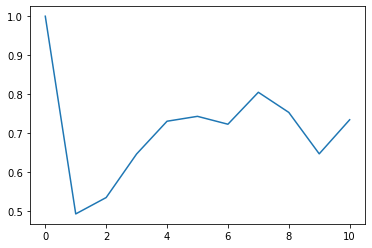

In [103]:
plt.plot(list(range(len(arr0))), cos0)

###### 画t-sne

In [68]:
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

t-SNE: 0.1 sec


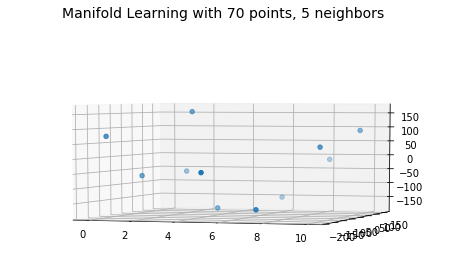

In [85]:
n_neighbors = 5
n_components = 2

t0 = time()
tsne = TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(arr0)  # 转换后的输出
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))  # 算法用时

fig = plt.figure(figsize=(8, 8))
# 创建了一个figure，标题为"Manifold Learning with 1000 points, 10 neighbors"
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (70, n_neighbors), fontsize=14)

ax = fig.add_subplot(211, projection='3d')

ax.scatter(list(range(len(arr0))), Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
ax.view_init(4, -72)  # 初始化视角
# plt.axis('tight')
plt.show()

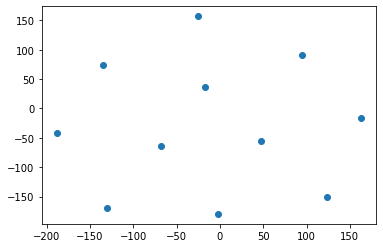

In [88]:
plt.scatter(Y[:, 0], Y[:, 1])

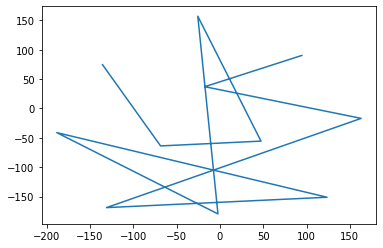

In [89]:
plt.plot(Y[:, 0], Y[:, 1])

#### 开发调试模型

In [43]:
import matplotlib.pyplot as plt

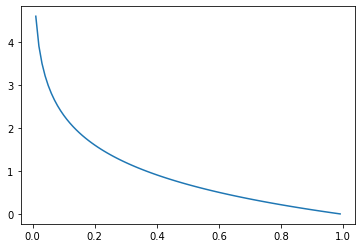

In [62]:
plt.plot(x, -1*y1)

> log 曲线和　log_sum曲线的变化是一致的，只是数值更小了，所以更换的意义也不大，不如换成曲线

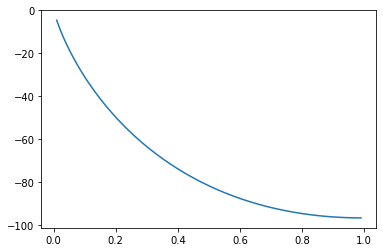

In [61]:
plt.plot(x, y2)

> 越靠近终点，得到的奖励值就越大，但是会趋近于平缓，所以会选择观察分类错误的值。但是在太前面了，又无法做到正确分类，分类误差占据主要，因此还是难以得到理想的折中结果。

In [18]:
t_steps=10000, 
stage=0
new_data_len=[] 
valid_new_len=[]
logger=None
log_dir="RDMBertTrain"
cuda=True

In [32]:
batch_size = 20
sum_loss = 0.0
sum_acc = 0.0
t_acc = 0.9
ret_acc = 0.0
init_states = torch.zeros([1, batch_size, rdm_model.hidden_dim], dtype=torch.float32).cuda()
weight = torch.tensor([2.0, 1.0], dtype=torch.float32).cuda()
loss_fn = nn.CrossEntropyLoss(weight=weight)

In [37]:
x, x_len, y = get_df_batch(0, 20)

In [38]:
seq = sent_pooler(x)
rdm_hiddens = rdm_model(seq)
# rdm_hiddens, rdm_out, rdm_cell = rdm_model(seq, x_len.tolist())
batchsize, max_seq_len, hidden_dim = rdm_hiddens.shape

In [39]:
stopScore, isStop = cm_model(rdm_hiddens.reshape(-1, 256))
isStop = isStop.reshape([batchsize, max_seq_len, -1])
stopProb = stopScore.reshape([batchsize, max_seq_len, -1]).softmax(axis=-1)         

In [69]:
(stopProb[0][5:10,1] - 0.60).sum()

tensor(-1.2506, device='cuda:0', grad_fn=<SumBackward0>)

In [62]:
s1 = torch.stack([stopProb[j][x_len[j]-1] for j in range(len(x_len))])

In [40]:
cls_rst = rdm_classifier(rdm_hiddens.reshape(-1, hidden_dim)).reshape([batchsize, max_seq_len, -1])

In [41]:
y[2]

array([0, 1], dtype=int32)

In [42]:
[(idx, l) for idx, l in enumerate(cls_rst.tolist()[0][:x_len[0]])]

[(0, [-0.9198921322822571, 0.4010252356529236]),
 (1, [-1.6395022869110107, 0.872894287109375]),
 (2, [-2.094587564468384, 1.2539931535720825]),
 (3, [-2.9889392852783203, 2.109062910079956]),
 (4, [-3.650022029876709, 2.771613597869873]),
 (5, [-4.069356441497803, 3.2355637550354004]),
 (6, [-4.214232921600342, 3.4247078895568848]),
 (7, [-4.047580242156982, 3.2036712169647217]),
 (8, [-4.1708221435546875, 3.312376022338867]),
 (9, [-4.416569232940674, 3.557356834411621]),
 (10, [-4.4399800300598145, 3.506744384765625]),
 (11, [-4.201022148132324, 3.3456838130950928]),
 (12, [-4.09346342086792, 3.2183890342712402]),
 (13, [-4.089611053466797, 3.2429821491241455]),
 (14, [-4.0455217361450195, 3.2066378593444824]),
 (15, [-4.175084114074707, 3.3041985034942627]),
 (16, [-3.9259774684906006, 3.0843892097473145]),
 (17, [-3.8927388191223145, 3.0498080253601074]),
 (18, [-4.036046981811523, 3.2023465633392334]),
 (19, [-4.149847507476807, 3.2340102195739746]),
 (20, [-4.059919834136963, 3.

In [43]:
[(idx, l) for idx, l in enumerate(stopProb.tolist()[0][:x_len[0]])]

[(0, [0.6712271571159363, 0.3287728726863861]),
 (1, [0.702727198600769, 0.2972727417945862]),
 (2, [0.7010159492492676, 0.29898402094841003]),
 (3, [0.6861575245857239, 0.31384241580963135]),
 (4, [0.6787883639335632, 0.32121166586875916]),
 (5, [0.6611488461494446, 0.3388511538505554]),
 (6, [0.6303197741508484, 0.3696802854537964]),
 (7, [0.6430903673171997, 0.3569096624851227]),
 (8, [0.6667971611022949, 0.3332028090953827]),
 (9, [0.6492486596107483, 0.3507513999938965]),
 (10, [0.6633690595626831, 0.33663100004196167]),
 (11, [0.6694027185440063, 0.3305973410606384]),
 (12, [0.6796047687530518, 0.32039520144462585]),
 (13, [0.677090048789978, 0.3229099214076996]),
 (14, [0.6740487217903137, 0.32595130801200867]),
 (15, [0.6616612076759338, 0.3383387625217438]),
 (16, [0.6502946019172668, 0.3497053384780884]),
 (17, [0.6481865644454956, 0.3518134355545044]),
 (18, [0.6494060754776001, 0.3505939841270447]),
 (19, [0.6450322270393372, 0.35496780276298523]),
 (20, [0.6571367383003235

### 原始CM模型

In [20]:
class CM_Model_V1(nn.Module):
    def __init__(self, hidden_dim, action_num):
        super(CM_Model_V1, self).__init__()
        self.hidden_dim = hidden_dim
        self.action_num = action_num
        self.DenseLayer = nn.Linear(self.hidden_dim, 64)
        self.Classifier = nn.Linear(64, self.action_num)
        
    def forward(self, rdm_state):
        """
        rdm_state: [batchsize, hidden_dim]
        """
        batchsize, hidden_dim = rdm_state.shape
        rl_h1 = nn.functional.relu(
            self.DenseLayer(
                rdm_state
            )
        )
        stopScore = self.Classifier(rl_h1)
        isStop = stopScore.argmax(axis=1)
        return stopScore, isStop

class CM_Model(nn.Module):
    def __init__(self, sentence_embedding_dim, hidden_dim, action_num):
        super(CM_Model, self).__init__()
        self.sentence_embedding_dim = sentence_embedding_dim
        self.hidden_dim = hidden_dim
        self.action_num = action_num
#         self.PoolLayer = pooling_layer(self.embedding_dim, 
#                                             self.hidden_dim)
        self.DenseLayer = nn.Linear(self.hidden_dim, 64)
        self.Classifier = nn.Linear(64, self.action_num)
        
    def forward(self, rdm_model, rl_input, rl_state):
        """
        rl_input: [batchsize, max_word_num, sentence_embedding_dim]
        rl_state: [1, batchsize, hidden_dim]
        """
        assert(rl_input.ndim==3)
        batchsize, max_word_num, embedding_dim = rl_input.shape
        rl_output, rl_new_state = rdm_model.gru_model(
                                            rl_input, 
                                            rl_state
                                        )
        rl_h1 = nn.functional.relu(
            self.DenseLayer(
#                 rl_state.reshape([len(rl_input), self.hidden_dim]) #it is not sure to take rl_state , rather than rl_output, as the feature
                rl_output.reshape(
                    [len(rl_input), self.hidden_dim]
                )
            )
        )
        stopScore = self.Classifier(rl_h1)
        isStop = stopScore.argmax(axis=1)
        return stopScore, isStop, rl_new_state

In [21]:
def TrainCMModel(sent_pooler, rdm_model, rdm_classifier, cm_model, stage, t_rw, t_steps, log_dir, logger, FLAGS, cuda=True):
    batch_size = 20
    t_acc = 0.9
    ids = np.array(range(batch_size), dtype=np.int32)
    seq_states = np.zeros([batch_size], dtype=np.int32)
    isStop = np.zeros([batch_size], dtype=np.int32)
    max_id = batch_size
    df_init_states = torch.zeros([1, batch_size, rdm_model.hidden_dim], dtype=torch.float32).cuda()
    writer = SummaryWriter(log_dir, filename_suffix="_ERD_CM_stage_%3d"%stage)
    state = df_init_states
    D = deque()
    ssq = []
    print("in RL the begining")
    rl_optim = torch.optim.Adam([{'params':cm_model.parameters(), 'lr':1e-5}])
    # get_new_len(sess, mm)
    data_ID = get_data_ID()

    if len(data_ID) % batch_size == 0: # the total number of events
            flags = int(len(data_ID) / FLAGS.batch_size)
    else:
        flags = int(len(data_ID) / FLAGS.batch_size) + 1

    rdm_hiddens_seq = []
    for i in range(flags):
        with torch.no_grad():
            x, x_len, y = get_df_batch(i, batch_size)
            seq = sent_pooler(x)
            rdm_hiddens = rdm_model(seq)
            batchsize, _, _ = rdm_hiddens.shape
            tmp_hiddens = [ rdm_hiddens[i][:x_len[i]] for i in range(batchsize)] 

            rdm_hiddens_seq.extend(tmp_hiddens)
            print("batch %d"%i)
            if len(ssq) > 0:
                ssq.extend([rdm_classifier(h) for h in tmp_hiddens])
            else:
                ssq = [rdm_classifier(h) for h in tmp_hiddens]
            torch.cuda.empty_cache()
    del rdm_hiddens, tmp_hiddens

    print(get_curtime() + " Now Start RL training ...")

    counter = 0
    sum_rw = 0.0 # sum of rewards
    data_len = get_data_len()

    while True:
    #         if counter > FLAGS.OBSERVE:
        if counter > 1000:
            if counter > t_steps:
                print("Retch The Target Steps")
                break
            rdm_state, s_ids, s_seq_states = get_RL_Train_batch_V1(D, FLAGS, batch_size, cuda)
            print("s_seq_states:", s_seq_states)
            with torch.no_grad():
                s_stopScore, s_isStop = cm_model(rdm_state)                
                rw, q_val = get_reward_0(s_isStop, s_stopScore, ssq, s_ids, s_seq_states)

            s_isStop = s_stopScore.argsort()
            for j in range(batch_size):
                if random.random() < FLAGS.random_rate:
                    s_isStop[j][int(torch.rand(2).argmax())] = 1 # 设置了一个随机的干扰。
                if seq_states[j] == data_len[s_ids[j]]:
                    s_isStop[j] = 1

            t_stopScore, t_isStop = cm_model(rdm_state)
            out_action = (t_stopScore*s_isStop.float()).sum(axis=1)
            rl_cost = torch.mean((q_val.cuda() - out_action)*(q_val.cuda() - out_action))
            rl_cost.backward()
            torch.cuda.empty_cache()
            rl_optim.step()
            print("RL Cost:", rl_cost)
            writer.add_scalar('RL Cost', rl_cost, counter - FLAGS.OBSERVE)

        ids, seq_states, max_id = get_rl_batch(ids, seq_states, max_id, 0, FLAGS)
        if counter > FLAGS.OBSERVE:
            print("step:", counter - FLAGS.OBSERVE, ", reward:", rw.mean())
            print("step:", counter - FLAGS.OBSERVE, ", reward:", q_val.mean())
            writer.add_scalar('reward', rw.mean(), counter - FLAGS.OBSERVE)
        for j in range(batch_size):
            D.append((rdm_hiddens_seq[ids[j]][seq_states[j]-1], ids[j], seq_states[j]))
            if len(D) > FLAGS.max_memory:
                D.popleft()
        counter += 1

In [22]:
cm_model = CM_Model_V1(256, 2).cuda()

In [23]:
with open("../../config.json", "r") as cr:
    dic = json.load(cr)

class adict(dict):
    ''' Attribute dictionary - a convenience data structure, similar to SimpleNamespace in python 3.3
        One can use attributes to read/write dictionary content.
    '''
    def __init__(self, *av, **kav):
        dict.__init__(self, *av, **kav)
        self.__dict__ = self

FLAGS = adict(dic)

In [24]:
del data_ID
del data_len
del data_y
del data

from dataUtils import data_ID
from dataUtils import data_len
from dataUtils import data_y
from dataUtils import data

In [27]:
cuda = True

In [112]:
x, x_len, y = get_df_batch(0, 20)
seq = sent_pooler(x)
rdm_hiddens = rdm_model(seq)
batchsize, _, _ = rdm_hiddens.shape
rdm_outs = torch.cat(
    [ rdm_hiddens[i][x_len[i]-1].unsqueeze(0) for i in range(batchsize)] 
    # a list of tensor, where the ndim of tensor is 1 and the shape of tensor is [hidden_size]
)
rdm_scores = rdm_classifier(
    rdm_outs
)
rdm_preds = rdm_scores.argmax(axis=1)
y_label = torch.tensor(y).argmax(axis=1).cuda() if cuda else torch.tensor(y).argmax(axis=1)

In [113]:
batchsize, max_seq_len, _ = rdm_hiddens.shape

stopScore, isStop = cm_model(rdm_hiddens.reshape(-1, 256))

isStop = isStop.reshape([batchsize, max_seq_len, -1])
stopScore = stopScore.reshape([batchsize, max_seq_len, -1]).softmax(axis=-1)

##### 计算奖励值
$P_{s_ts_{t+1}}^{stop} = 0.2$, $P_{s_ts_{t+1}}^{continue} = 1.0$

In [89]:
import random

In [114]:

E_rw = torch.zeros(len(x_len)).cuda()
prob = torch.ones(len(x_len)).cuda()
for j in range(len(x_len)):
    sum_rw = 0.0
    for t in range(x_len[j]):
        if random.random() < stopScore[j][t][0]:
            rw = -2.0/x_len[j]
            sum_rw += pow(gamma, t)*rw
            prob[j] *= stopScore[j][t][0]            
        else:
            if y[t][1] == 1:
                rw = 1.0
            else:
                rw = -1.0
            sum_rw += pow(gamma, t)*rw
            prob[j] *= stopScore[j][t][1]
            if random.random() > stopScore[j][t][0]*0.8:
                prob[j] *= 0.2
                continue
            else:
                prob[j] *= 0.8
                break
    E_rw[j] = prob[j]*sum_rw

In [115]:
E_rw.mean()

tensor(0.0480, device='cuda:0', grad_fn=<MeanBackward0>)

In [116]:
E_rw.mean().backward()

In [135]:
cm_model.Classifier.bias.grad

tensor([-0.1501,  0.1501], device='cuda:0')

In [124]:
cm_model.parameters

<bound method Module.parameters of CM_Model_V1(
  (DenseLayer): Linear(in_features=256, out_features=64, bias=True)
  (Classifier): Linear(in_features=64, out_features=2, bias=True)
)>

In [128]:
cm_model.DenseLayer.weight.grad[:, 2]

tensor([ 2.3243e-03, -3.7346e-03, -2.2496e-03,  2.0127e-04, -7.0226e-07,
        -1.2231e-06,  3.0092e-03,  1.0209e-04,  5.1023e-04,  5.8671e-04,
        -3.3503e-03,  2.3306e-04, -1.0836e-03,  1.2252e-04,  1.2734e-06,
         1.7792e-03, -3.6655e-04,  1.1308e-03,  1.3898e-04, -2.3393e-04,
         7.9612e-05,  1.0782e-03,  2.8988e-03, -2.0485e-03,  0.0000e+00,
         1.4991e-05, -1.3598e-03,  2.5439e-03,  0.0000e+00,  2.6299e-03,
         0.0000e+00,  7.8712e-04, -2.0296e-04,  1.1501e-03,  0.0000e+00,
        -3.3561e-06, -2.4082e-03, -3.2616e-03,  1.3546e-03, -2.5670e-03,
         2.5143e-04,  1.2142e-04,  3.6075e-03, -1.6696e-03, -3.6478e-03,
         3.9861e-04, -6.5540e-04, -2.1520e-05, -3.7279e-04, -3.0819e-03,
        -1.5073e-03, -1.4589e-03,  1.0510e-03, -8.2171e-04,  1.2041e-03,
        -2.9462e-04,  0.0000e+00,  2.3378e-03,  2.4727e-03,  2.6905e-03,
        -2.4922e-09,  1.2005e-03,  2.3503e-03, -2.8909e-03], device='cuda:0')

In [111]:
y

array([[0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0]], dtype=int32)

In [109]:
random.randint(0, 10)

9

In [110]:
TrainCMModel(sent_pooler, rdm_model, rdm_classifier, cm_model, 0, 0.5, 20000, "ERD/", None, FLAGS, cuda=True)

in RL the begining
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8


KeyboardInterrupt: 

In [102]:
from dataUtils import valid_data_ID
from dataUtils import valid_data_len
from dataUtils import valid_data_y

In [116]:
rst = get_new_len(sent_pooler, rdm_model, cm_model, FLAGS, cuda)

NameError: name 'new_len' is not defined

In [117]:
log_dir = os.path.join(sys.path[0], "ERD/")

## ERD_Torch

In [1]:
import sys
import random
import torch
import importlib
from tensorboardX import SummaryWriter
import torch.nn.utils.rnn as rnn_utils
import pickle
import tqdm
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import deque
sys.path.append(".")
from dataUtilsV0 import *
import json
from RDM_Model import *
from CM_Model import *

load glove finished


In [2]:
del data
del data_ID
del data_len
del data_y
del valid_data_ID
del valid_data_len
del valid_data_y
from dataUtilsV0 import data
from dataUtilsV0 import data_ID
from dataUtilsV0 import data_len
from dataUtilsV0 import data_y
from dataUtilsV0 import valid_data_ID
from dataUtilsV0 import valid_data_len
from dataUtilsV0 import valid_data_y

In [3]:
class pooling_layer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(pooling_layer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def forward(self, inputs, cuda=True):
        inputs_sent = [torch.cat([self.linear(sent_tensor.cuda() if cuda else sent_tensor).max(axis=0)[0].unsqueeze(0) for sent_tensor in seq]) for seq in inputs]
        seqs = torch.nn.utils.rnn.pad_sequence(inputs_sent, batch_first=True)
        return seqs

class RDM_Model(nn.Module):
    def __init__(self, word_embedding_dim, sent_embedding_dim, hidden_dim, dropout_prob):
        super(RDM_Model, self).__init__()
        self.embedding_dim = sent_embedding_dim
        self.hidden_dim = hidden_dim
        self.gru_model = nn.GRU(word_embedding_dim, 
                                self.hidden_dim, 
                                batch_first=True, 
                                dropout=dropout_prob
                            )
        self.DropLayer = nn.Dropout(dropout_prob)

    def forward(self, input_x): 
        """
        input_x: [batchsize, max_seq_len, sentence_embedding_dim] 
        x_len: [batchsize]
        init_states: [batchsize, hidden_dim]
        """
        batchsize, max_seq_len, emb_dim = input_x.shape
        init_states = torch.zeros([1, batchsize, self.hidden_dim], dtype=torch.float32).cuda()
        try:
            df_outputs, df_last_state = self.gru_model(input_x, init_states)
        except:
            print("Error:", pool_feature.shape, init_states.shape)
            raise
        return df_outputs

class RDM_Model_V1(nn.Module):
    def __init__(self, word_embedding_dim, sent_embedding_dim, hidden_dim, dropout_prob):
        super(RDM_Model_V1, self).__init__()
        self.embedding_dim = sent_embedding_dim
        self.hidden_dim = hidden_dim
        self.gru_model = LayerNormLSTM(word_embedding_dim, 
                                self.hidden_dim, 
                                dropout=dropout_prob
                            )

    def forward(self, input_x, seq_lens): 
        """
        input_x: [batchsize, max_seq_len, sentence_embedding_dim] 
        x_len: [batchsize]
        init_states: [batchsize, hidden_dim]
        """
        batchsize, max_seq_len, emb_dim = input_x.shape
        h0 = torch.zeros([1, batchsize, self.hidden_dim], dtype=torch.float32).cuda()
        c0 = torch.zeros([1, batchsize, self.hidden_dim], dtype=torch.float32).cuda()
        df_outputs, (df_last_state, df_last_cell) = self.gru_model(input_x.transpose(0, 1), (h0, c0), seq_lens)
        return df_outputs.transpose(0, 1), df_last_state.transpose(0, 1), df_last_cell.transpose(0, 1)

class CM_Model_V1(nn.Module):
    def __init__(self, hidden_dim, action_num):
        super(CM_Model_V1, self).__init__()
        self.hidden_dim = hidden_dim
        self.action_num = action_num
        self.DenseLayer = nn.Linear(self.hidden_dim, 64)
        self.Classifier = nn.Linear(64, self.action_num)
        
    def forward(self, rdm_state):
        """
        rdm_state: [batchsize, hidden_dim]
        """
        batchsize, hidden_dim = rdm_state.shape
        rl_h1 = nn.functional.relu(
            self.DenseLayer(
                rdm_state
            )
        )
        stopScore = self.Classifier(rl_h1)
        isStop = stopScore.argmax(axis=1)
        return stopScore, isStop

class CM_Model(nn.Module):
    def __init__(self, sentence_embedding_dim, hidden_dim, action_num):
        super(CM_Model, self).__init__()
        self.sentence_embedding_dim = sentence_embedding_dim
        self.hidden_dim = hidden_dim
        self.action_num = action_num
#         self.PoolLayer = pooling_layer(self.embedding_dim, 
#                                             self.hidden_dim)
        self.DenseLayer = nn.Linear(self.hidden_dim, 64)
        self.Classifier = nn.Linear(64, self.action_num)
        
    def forward(self, rdm_model, rl_input, rl_state):
        """
        rl_input: [batchsize, max_word_num, sentence_embedding_dim]
        rl_state: [1, batchsize, hidden_dim]
        """
        assert(rl_input.ndim==3)
        batchsize, max_word_num, embedding_dim = rl_input.shape
        rl_output, rl_new_state = rdm_model.gru_model(
                                            rl_input, 
                                            rl_state
                                        )
        rl_h1 = nn.functional.relu(
            self.DenseLayer(
#                 rl_state.reshape([len(rl_input), self.hidden_dim]) #it is not sure to take rl_state , rather than rl_output, as the feature
                rl_output.reshape(
                    [len(rl_input), self.hidden_dim]
                )
            )
        )
        stopScore = self.Classifier(rl_h1)
        isStop = stopScore.argmax(axis=1)
        return stopScore, isStop, rl_new_state

In [4]:
load_data_fast()

rdm_model = RDM_Model(300, 300, 256, 0.2).cuda()
sent_pooler = pooling_layer(300, 300).cuda()
rdm_classifier = nn.Linear(256, 2).cuda()
cm_model = CM_Model_V1(256, 2).cuda()

log_dir = os.path.join(sys.path[0], "ERDV4/")

max_sent: 64 ,  max_seq_len: 346
5802 data loaded


/home/hadoop/.conda/envs/torch_B/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [17]:
pretrained_file = "ERDV4/ERD_best.pkl"
if os.path.exists(pretrained_file):
    checkpoint = torch.load(pretrained_file)
    sent_pooler.load_state_dict(checkpoint['sent_pooler'])
    rdm_model.load_state_dict(checkpoint["rmdModel"])
    rdm_classifier.load_state_dict(checkpoint["rdm_classifier"])

In [5]:
pretrained_file = '%s/erdModel_epoch%03d.pkl'% ("ERDV4" , 0)
if os.path.exists(pretrained_file):
    checkpoint = torch.load(pretrained_file)
    sent_pooler.load_state_dict(checkpoint['sent_pooler'])
    rdm_model.load_state_dict(checkpoint["rmdModel"])
    rdm_classifier.load_state_dict(checkpoint["rdm_classifier"])
    cm_model.load_state_dict(checkpoint["cm_model"])

In [ ]:
TrainCMModel_V0(sent_pooler, rdm_model, rdm_classifier, cm_model, 0, 0, 20000, 'ERD', None, FLAGS, cuda=True)

In [6]:
valid_new_len = get_new_len_on_valid_data(sent_pooler, rdm_model, cm_model, FLAGS, cuda=True)

In [7]:
valid_new_len

[1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 23,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 3,
 4,
 1,
 1,
 1,
 1,
 19,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 16,
 1,
 1,
 1,
 1,
 2,
 3,
 1,
 1,
 1,
 5,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 4,
 10,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 6,
 1,
 1,
 5,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 6,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 4,
 2,
 1,
 3,
 1,
 1,
 1,
 4,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 4,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 39,
 2,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 3,
 8,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 5,
 1,
 1,
 17,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 4,
 1,
 1,
 1,
 1,
 3,
 4,
 1,
 1,
 1,
 1,
 1,
 6,
 4,
 1,
 1,
 1,
 16,
 1,
 1,
 1,
 1,
 2,
 4,
 1,
 1,
 1,
 2,
 

In [8]:
valid_data_len = get_valid_data_len()

In [10]:
import numpy as np

In [9]:
valid_new_len = [16,6,27,16,18,36,8,14,32,5,5,22,23,20,15,33,6,8,22,27,12,12,10,26,48,20,32,9,14,46,12,7,19,11,19,53,23,18,27,12,18,32,17,15,17,36,18,14,13,11,21,16,11,19,26,10,35,9,22,19,19,23,19,14,20,13,6,12,5,14,9,14,11,19,39,18,19,5,22,9,12,20,29,9,6,58,34,21,18,37,8,18,177,10,11,21,27,26,59,7,19,20,35,16,6,18,7,7,10,14,14,37,15,82,11,11,20,36,7,14,7,9,6,132,5,22,9,12,12,21,18,8,133,18,37,25,5,28,9,6,20,17,34,14,12,10,17,15,6,21,6,9,11,8,11,18,15,15,8,5,21,10,15,18,29,38,10,12,6,5,7,38,15,20,38,15,159,7,12,10,9,17,8,21,20,18,17,20,6,19,8,39,8,6,28,11,20,22,31,10,11,19,28,16,56,13,28,15,13,24,16,107,18,17,20,15,7,22,7,13,12,5,27,28,5,18,5,15,7,19,21,6,32,24,15,7,10,15,22,17,20,5,5,19,11,49,9,11,17,13,17,40,10,13,19,17,10,16,5,21,18,11,20,12,13,38,38,13,31,15,6,19,9,23,19,19,9,23,8,10,28,10,6,16,8,19,5,15,46,16,10,16,10,26,26,20,15,61,6,16,7,24,109,10,8,45,19,13,60,20,43,7,11,106,6,16,17,18,19,17,6,35,12,13,30,9,23,12,12,6,18,19,49,19,12,23,24,14,20,10,13,13,20,18,10,21,19,24,9,19,24,8,5,13,7,5,14,12,19,39,12,19,57,18,10,5,5,36,14,8,19,13,24,84,15,19,13,22,32,20,16,19,28,45,8,45,7,12,11,19,22,23,13,42,8,17,6,19,19,25,18,27,18,32,20,6,13,8,8,16,22,26,15,10,26,9,12,18,23,8,34,10,23,24,38,10,35,29,9,52,11,21,43,21,14,19,9,12,8,13,10,7,32,54,19,46,15,15,14,19,18,11,7,18,20,16,19,7,18,17,14,8,6,5,11,11,19,9,10,18,20,11,7,19,18,39,23,108,5,38,13,10,37,5,8,19,9,19,8,19,35,21,11,10,9,19,19,9,6,5]
valid_new_len = np.array(valid_data_len)-np.array(valid_new_len)

In [11]:
accuracy_on_valid_data(rdm_model, sent_pooler, rdm_classifier, valid_new_len)

(0.772, 0.9291338582677166, 0.7108433734939759)

#### CM模型的开发测试

In [16]:
stage = 0
t_rw = 0.9 
t_steps = 1000 
logger = None 
cuda=True

In [22]:
with open('ssq.pickle', 'wb') as handle:
    pickle.dump(ssq, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open('ssq.pickle', 'rb') as handle:
    ssq = pickle.load(handle)

In [17]:
del data
del data_len
del data_ID
del data_y
from dataUtilsV0 import data
from dataUtilsV0 import data_len
from dataUtilsV0 import data_y
from dataUtilsV0 import data_ID

In [18]:
batch_size = 20
t_acc = 0.9
ids = np.array(range(batch_size), dtype=np.int32)
seq_states = np.zeros([batch_size], dtype=np.int32)
isStop = torch.zeros([batch_size], dtype=torch.int32)
max_id = batch_size
df_init_states = torch.zeros([1, batch_size, rdm_model.hidden_dim], dtype=torch.float32).cuda()
writer = SummaryWriter(log_dir, filename_suffix="_ERD_CM_stage_%3d"%stage)
D = deque()
ssq = []
print("in RL the begining")
rl_optim = torch.optim.Adam([{'params': sent_pooler.parameters(), 'lr': 5e-3},
                                {'params': rdm_model.parameters(), 'lr': 5e-3},
                             {'params':cm_model.parameters(), 'lr':1e-5}])
# get_new_len(sess, mm)
data_ID = get_data_ID()

if len(data_ID) % batch_size == 0: # the total number of events
    flags = int(len(data_ID) / FLAGS.batch_size)
else:
    flags = int(len(data_ID) / FLAGS.batch_size) + 1


in RL the begining


In [20]:
for i in range(flags):
    with torch.no_grad():
        x, x_len, y = get_df_batch(i, batch_size)
        seq = sent_pooler(x)
        rdm_hiddens = rdm_model(seq)
        batchsize, _, _ = rdm_hiddens.shape
        print("batch %d"%i)
        if len(ssq) > 0:
            ssq.extend([rdm_classifier(h) for h in rdm_hiddens])
        else:
            ssq = [rdm_classifier(h) for h in rdm_hiddens]
        torch.cuda.empty_cache()

batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50
batch 51
batch 52
batch 53
batch 54
batch 55
batch 56
batch 57
batch 58
batch 59
batch 60
batch 61
batch 62
batch 63
batch 64
batch 65
batch 66
batch 67
batch 68
batch 69
batch 70
batch 71
batch 72
batch 73
batch 74
batch 75
batch 76
batch 77
batch 78
batch 79
batch 80
batch 81
batch 82
batch 83
batch 84
batch 85
batch 86
batch 87
batch 88
batch 89
batch 90
batch 91
batch 92
batch 93
batch 94
batch 95
batch 96
batch 97
batch 98
batch 99
batch 100
batch 101
batch 102
batch 103
batch 104
batch 105
batch 106
batch 107
batch 108
batch 109
batch 110


In [18]:
x, y, ids, seq_states, max_id = get_rl_batch_0(ids, seq_states, isStop, max_id, 0)
for j in range(FLAGS.batch_size):
    if seq_states[j] == 1:
        df_init_states[0][j].fill_(0.0)
with torch.no_grad():
    word_tensors = torch.tensor(x)
    batchsize, max_sent_len, emb_dim = word_tensors.shape
    sent_tensor = sent_pooler.linear(word_tensors.reshape([-1, emb_dim]).cuda()).reshape([batchsize, max_sent_len, emb_dim]).max(axis=1)[0].unsqueeze(1)
    df_outs, df_last_state = rdm_model.gru_model(sent_tensor, df_init_states)
    batchsize, _, hidden_dim = df_outs.shape
    stopScore, isStop = cm_model(df_outs.reshape([-1, hidden_dim]))
    
for j in range(batch_size):
    if random.random() < FLAGS.random_rate:
        isStop[j] = np.argmax(np.random.rand(2))
    if seq_states[j] == data_len[ids[j]]:
        isStop[j] = 1
rw, Q_val = get_reward_0(isStop, stopScore, ssq, ids, seq_states)
for j in range(FLAGS.batch_size):
    D.append((df_init_states[0][j], x[j], isStop[j], rw[j]))
    if len(D) > FLAGS.max_memory:
        D.popleft()
df_init_states = df_last_state

In [16]:
s_state, s_x, s_isStop, s_rw = get_RL_Train_batch(D)
word_tensors = torch.tensor(s_x)
batchsize, max_sent_len, emb_dim = word_tensors.shape
sent_tensor = sent_pooler.linear(word_tensors.reshape([-1, emb_dim]).cuda()).reshape([batchsize, max_sent_len, emb_dim]).max(axis=1)[0].unsqueeze(1)
df_outs, df_last_state = rdm_model.gru_model(sent_tensor, s_state.unsqueeze(0).cuda())
batchsize, _, hidden_dim = df_outs.shape
stopScore, isStop = cm_model(df_outs.reshape([-1, hidden_dim]))
out_action = (stopScore*s_isStop.cuda()).sum(axis=1)
rl_cost = torch.pow(s_rw.cuda() - out_action, 2).mean()

In [ ]:
if counter > FLAGS.OBSERVE:
    sum_rw += np.mean(rw)
    if counter % 200 == 0:
        sum_rw = sum_rw / 2000
        print(get_curtime() + " Step: " + str(step) + " REWARD IS " + str(sum_rw))
        if sum_rw > t_rw:
            print("Retch The Target Reward")
            break
        if counter > t_steps:
            print("Retch The Target Steps")
            break
        sum_rw = 0.0
    s_state, s_x, s_isStop, s_rw = get_RL_Train_batch(D)
    word_tensors = torch.tensor(s_x)
    batchsize, max_sent_len, emb_dim = word_tensors.shape
    sent_tensor = sent_pooler.linear(word_tensors.reshape([-1, emb_dim]).cuda()).reshape([batchsize, max_sent_len, emb_dim]).max(axis=1)[0].unsqueeze(1)
    df_outs, df_last_state = rdm_model.gru_model(sent_tensor, s_state.unsqueeze(0).cuda())
    batchsize, _, hidden_dim = df_outs.shape
    stopScore, isStop = cm_model(df_outs.reshape([-1, hidden_dim]))
    out_action = (stopScore*s_isStop.cuda()).sum(axis=1)
    rl_cost = torch.pow(s_rw.cuda() - out_action, 2).mean()

## 模型的测试

### 画图的函数

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
def plot_hist(x_tuples, bins, xlabel, ylabel, legends, title):
    colors = [(1, 0, 0), (1, 1, 0), (0, 1, 0,), (0, 0, 1)]
    def normfun(x,mu,sigma):
        pdf = np.exp(-((x - mu)**2)/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
        return pdf
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
#     plt.xlim(0, 1)
    for i in range(len(x_tuples)):
        sns.distplot(x_tuples[i], bins=bins, rug=False, kde=True, hist=True, norm_hist=True, label=legends[i], hist_kws={"histtype": "step", "linewidth": 2,
        "alpha": 1}, kde_kws={"color": colors[0], "lw": 0, "label": ""})

### 测试代码

In [6]:
del valid_data_ID
del valid_data_len
del valid_data_y

In [7]:
del data

In [8]:
from dataUtilsV0 import data

In [9]:
from dataUtilsV0 import valid_data_ID
from dataUtilsV0 import valid_data_len
from dataUtilsV0 import valid_data_y

In [24]:
batch_size = 20
mts = 0
hit_vec = 0
miss_vec = 0
t_steps = int(len(valid_data_ID)/batch_size)
valid_new_len = []
for step in range(t_steps):
    data_x = []
    m_data_y = np.zeros([batch_size, 2], dtype=np.int32)
    m_data_len = np.zeros([batch_size], dtype=np.int32)
    for i in range(batch_size):
        m_data_y[i] = valid_data_y[mts]
        m_data_len[i] = valid_data_len[mts]
        seq = []
        for j in range(valid_data_len[mts]):
            sent = wordlist2wordvecs(data[valid_data_ID[mts]]['text'][j])
            sent_tensor = torch.tensor(np.stack(sent))
            seq.append(sent_tensor)
        data_x.append(seq)
        mts += 1
        if mts >= len(valid_data_ID): # read data looply
            mts = mts % len(valid_data_ID)
    with torch.no_grad():
        seq = sent_pooler(data_x)
        rdm_hiddens = rdm_model(seq)
        batchsize, _, _ = rdm_hiddens.shape
        rdm_outs = torch.cat(
            [ rdm_hiddens[i][m_data_len[i]-1] for i in range(batchsize)] 
            # a list of tensor, where the ndim of tensor is 1 and the shape of tensor is [hidden_size]
        ).reshape(
            [-1, rdm_model.hidden_dim]
        )
        stopScores = cm_model.Classifier(
                nn.functional.relu(
                    cm_model.DenseLayer(
                        rdm_hiddens.reshape([-1, rdm_model.hidden_dim])
                )
            )
        ).reshape(
            [batchsize, -1, 2]
        )
        isStop = stopScores.argmax(axis=-1).cpu().numpy()
        tmp_len = [iS.argmax()+1 if (iS.max() ==1 and (iS.argmax()+1)<m_data_len[iS_idx]) else m_data_len[iS_idx] for iS_idx, iS in enumerate(isStop)]
        for t_idx in range(len(tmp_len)):
            try:
                assert tmp_len[t_idx] <= m_data_len[t_idx]
            except:
                print("i:", t_idx)
                print("new_len:", tmp_len)
                print("data_len:", x_len)
                raise
    valid_new_len.extend(tmp_len)

In [20]:
isStop

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1

In [26]:
accuracy_on_valid_data(rdm_model, sent_pooler, rdm_classifier, new_data_len=valid_new_len, cuda=True)

(0.834, 0.8977635782747604, 0.8463855421686747)

In [28]:
valid_new_len2 = valid_new_len

In [27]:
valid_new_len1 = [17, 3, 1, 17, 3, 2, 1, 1, 1, 6, 1, 23, 1, 2, 16, 1, 1, 9, 4, 1, 1, 1, 1, 1, 2, 1, 33, 1, 1, 1, 2, 8, 2, 1, 5, 3, 24, 1, 28, 1, 4, 33, 1, 1, 1, 1, 1, 15, 1, 1, 22, 2, 12, 1, 27, 11, 1, 10, 1, 1, 1, 6, 20, 15, 1, 1, 1, 13, 6, 9, 8, 1, 2, 20, 1, 1, 1, 1, 23, 4, 13, 21, 1, 10, 7, 1, 1, 22, 19, 6, 9, 19, 2, 5, 1, 22, 3, 27, 1, 3, 20, 2, 2, 17, 7, 1, 1, 1, 11, 1, 15, 3, 1, 1, 12, 1, 1, 1, 8, 1, 8, 10, 7, 1, 6, 2, 10, 1, 1, 22, 1, 1, 1, 1, 2, 1, 2, 29, 1, 1, 21, 1, 1, 15, 1, 11, 1, 1, 1, 22, 2, 1, 1, 9, 1, 1, 16, 1, 9, 1, 1, 11, 1, 1, 30, 1, 1, 1, 1, 2, 1, 1, 8, 1, 2, 2, 1, 8, 13, 11, 8, 1, 1, 22, 21, 19, 1, 1, 1, 1, 1, 1, 7, 1, 3, 1, 1, 23, 1, 1, 2, 20, 29, 1, 2, 14, 1, 3, 1, 1, 1, 108, 3, 1, 1, 2, 8, 1, 1, 1, 13, 1, 1, 29, 6, 1, 2, 1, 1, 20, 22, 7, 3, 2, 16, 1, 1, 9, 1, 1, 21, 1, 1, 10, 1, 1, 3, 1, 1, 2, 2, 3, 1, 14, 1, 18, 11, 1, 2, 1, 19, 1, 1, 4, 1, 39, 2, 14, 2, 16, 1, 8, 10, 2, 2, 1, 1, 2, 1, 1, 1, 4, 1, 1, 1, 20, 1, 16, 1, 6, 11, 1, 11, 27, 27, 21, 1, 1, 7, 17, 1, 1, 1, 1, 1, 46, 2, 14, 1, 1, 2, 2, 1, 1, 1, 7, 2, 2, 1, 18, 2, 1, 1, 1, 31, 4, 2, 1, 13, 1, 1, 2, 1, 1, 1, 24, 1, 1, 21, 11, 1, 1, 21, 16, 1, 1, 5, 1, 1, 20, 1, 1, 1, 1, 1, 6, 1, 13, 4, 1, 1, 1, 1, 1, 11, 1, 1, 1, 3, 9, 4, 8, 1, 1, 1, 1, 14, 1, 10, 21, 5, 1, 1, 5, 9, 1, 1, 13, 12, 1, 1, 24, 1, 1, 9, 1, 7, 20, 1, 1, 19, 28, 19, 1, 1, 1, 14, 9, 1, 1, 1, 1, 16, 1, 1, 1, 1, 4, 24, 2, 1, 11, 24, 25, 39, 1, 1, 1, 3, 1, 12, 6, 1, 22, 1, 1, 2, 13, 1, 1, 11, 4, 33, 2, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 17, 6, 8, 19, 18, 1, 2, 1, 6, 1, 2, 1, 10, 1, 1, 21, 2, 8, 20, 19, 2, 1, 4, 1, 3, 14, 1, 38, 6, 1, 4, 1, 1, 9, 1, 1, 1, 12, 11, 1, 1, 1, 10, 7, 6]

In [30]:
len(valid_new_len1)

500

In [31]:
diff = np.array(valid_new_len1) - np.array(valid_new_len2)

In [32]:
diff.sum()

2265

In [33]:
diff.mean()

4.53

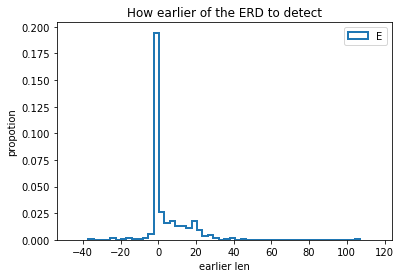

In [38]:
plot_hist([diff.tolist()], 50, "earlier len", "propotion", "ERD", "How earlier of the ERD to detect")

In [34]:
stopScores.shape

torch.Size([20, 38, 2])

In [15]:
[(m_data_len[i], isStop[i][:m_data_len[i]]) for i in range(20)]

[(14, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 (11, array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])),
 (38, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 (6, array([0, 0, 0, 0, 0, 0])),
 (9, array([1, 1, 1, 1, 1, 1, 1, 1, 1])),
 (20, array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])),
 (10, array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])),
 (20, array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])),
 (9, array([0, 0, 0, 0, 0, 0, 0, 0, 0])),
 (20, array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])),
 (36, array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])),
 (22,
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])),
 (12, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 (11, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 (10, array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])),

In [42]:
stopScores = stopScores.softmax(axis=-1)

In [45]:
stopScores[2, :38, 1].tolist()

[7.945952347654384e-06,
 0.4159657061100006,
 0.6594238877296448,
 0.1507825404405594,
 0.9997825026512146,
 0.040207237005233765,
 0.06709907948970795,
 0.01420875359326601,
 0.005813063122332096,
 0.002638801233842969,
 0.016022630035877228,
 0.007936082780361176,
 0.011414362117648125,
 0.0012879419373348355,
 0.00018256284238304943,
 0.0016160012455657125,
 0.004101844038814306,
 0.009587771259248257,
 0.0014243461191654205,
 0.0006178448093123734,
 0.002262902446091175,
 0.0005100546986795962,
 0.0068747494369745255,
 0.0004848391399718821,
 0.003096748376265168,
 0.0011317392345517874,
 0.004696405492722988,
 0.005269570276141167,
 0.017656641080975533,
 0.00031591212609782815,
 0.0005314438603818417,
 0.0003109482931904495,
 0.0004356719146016985,
 0.0073549943044781685,
 0.010789889842271805,
 0.0027212684508413076,
 0.0008097231620922685,
 0.017696592956781387]

In [43]:
[(m_data_len[i], stopScores[i, :m_data_len[i], 1].cpu().numpy()) for i in range(20)]

[(14, array([0.95983845, 0.9029102 , 0.99992645, 0.99998224, 1.        ,
         0.9316444 , 0.61939275, 0.99982256, 0.8852089 , 0.6623888 ,
         0.4934721 , 0.74092966, 0.62789583, 0.13294797], dtype=float32)),
 (11, array([9.9989986e-01, 1.7673745e-05, 9.2490119e-01, 9.9999809e-01,
         9.9994445e-01, 1.4531700e-03, 1.8196205e-06, 2.3836059e-02,
         6.3320367e-05, 2.1507431e-06, 1.5454854e-05], dtype=float32)),
 (38, array([7.9459523e-06, 4.1596571e-01, 6.5942389e-01, 1.5078254e-01,
         9.9978250e-01, 4.0207237e-02, 6.7099079e-02, 1.4208754e-02,
         5.8130631e-03, 2.6388012e-03, 1.6022630e-02, 7.9360828e-03,
         1.1414362e-02, 1.2879419e-03, 1.8256284e-04, 1.6160012e-03,
         4.1018440e-03, 9.5877713e-03, 1.4243461e-03, 6.1784481e-04,
         2.2629024e-03, 5.1005470e-04, 6.8747494e-03, 4.8483914e-04,
         3.0967484e-03, 1.1317392e-03, 4.6964055e-03, 5.2695703e-03,
         1.7656641e-02, 3.1591213e-04, 5.3144386e-04, 3.1094829e-04,
         4.35

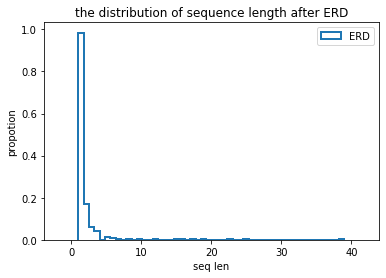

In [26]:
plot_hist([valid_new_len], 50, "seq len", "propotion", ["ERD"], "the distribution of sequence length after ERD")

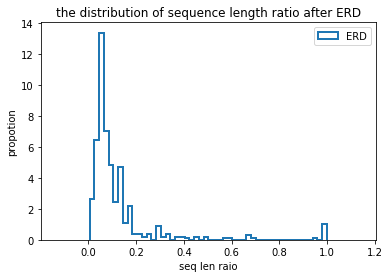

In [28]:
plot_hist([(np.array(valid_new_len))/np.array(valid_data_len).tolist()], 50, "seq len raio", "propotion", ["ERD"], "the distribution of sequence length ratio after ERD")